# Solution 3

__Date:__ October 22, 2018

<font color = gray>_Created by Tyler Evans_</font>

***
### Abstract:
> In this solution, I use DeltaEta, DeltaPhi, Mass, EhadOverEem, and pT. I don't separate the jets into pT bins. 
> 
> After training a neural network, I make a ROC curve and I find the AUC. 
>
> I also make a ratio plot for the gluon and quark pTs based off of their histograms.

***

## 0. Setup the notebook.

In [1]:
import os, sys
import ROOT as rt
from string import split
from ctypes import c_int, c_double
from treestream import itreestream, otreestream

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
# turn off ROOT use of javascript
%jsroot off

Welcome to JupyROOT 6.12/06
loaded treestream


## 1. Frame the problem and look at the big picture.

__Objective:__ Correctly discriminate between quark jets and gluon jets.

__Type:__ Supervised, binary classification task, batch learning.

__Performance measure:__ classification accuracy.

## 2. Get the data.

__Loading gluon-gluon events first.__

In [2]:
# update fonts
FONTSIZE = 32
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 28}
mp.rc('font', **font)


#Load gluon-gluon data
FILENAME_gluon = '../data/gg1.root'
TREENAME_gluon = 'Delphes'

#Load quark-quark data
FILENAME_quark = '../data/qq1.root'
TREENAME_quark = 'Delphes'

MAXJETS  = 20
VARIABLES= '''
Eta Phi PT Mass DeltaEta DeltaPhi EhadOverEem
'''
VARIABLES = split(VARIABLES)
VARIABLES

['Eta', 'Phi', 'PT', 'Mass', 'DeltaEta', 'DeltaPhi', 'EhadOverEem']

In [3]:
gluon_stream = itreestream(FILENAME_gluon, TREENAME_gluon)

quark_stream = itreestream(FILENAME_quark, TREENAME_quark)

Warning in <TClass::Init>: no dictionary for class HepMCEvent is available
Warning in <TClass::Init>: no dictionary for class Event is available
Warning in <TClass::Init>: no dictionary for class GenParticle is available
Warning in <TClass::Init>: no dictionary for class SortableObject is available
Warning in <TClass::Init>: no dictionary for class Track is available
Warning in <TClass::Init>: no dictionary for class Tower is available
Warning in <TClass::Init>: no dictionary for class Jet is available
Warning in <TClass::Init>: no dictionary for class MissingET is available
Warning in <TClass::Init>: no dictionary for class Electron is available
Warning in <TClass::Init>: no dictionary for class Photon is available
Warning in <TClass::Init>: no dictionary for class Muon is available
Warning in <TClass::Init>: no dictionary for class ScalarHT is available


In [4]:
class Buffer:
    pass
Jet = Buffer()

for v in VARIABLES:
    cmd = 'Jet.%s = rt.vector("float")(MAXJETS)' % v
    exec(cmd)

In [5]:
for v in VARIABLES:
    cmd = 'gluon_stream.select("Jet.%s", Jet.%s)' % (v, v)
    exec(cmd)
    
for v in VARIABLES:
    cmd = 'quark_stream.select("Jet.%s", Jet.%s)' % (v, v)
    exec(cmd)

In [6]:
gluon_entries = gluon_stream.size()
print "number of gluon-gluon events: %d" % gluon_entries

quark_entries = quark_stream.size()
print "number of quark-quark events: %d" % quark_entries

number of gluon-gluon events: 10000
number of quark-quark events: 10000


In [7]:
def create_dataframe(nt, entries, step=500):
    # create a map to hold selected jet data
    data = {}
    for v in VARIABLES:
        cmd = 'data["%s"] = []' % v
        exec(cmd)

    count = 0
    for entry in range(entries):
        nt.read(entry)
    
        # select jet data
        if Jet.Eta.size() < 1: continue
        #if Jet.PT[0] < 1000:    continue
        #if abs(Jet.Eta[0]) > 0.5: continue
      
        if count % step == 0:
            print "%5d\t%5d\tnumber of jets: %d" % (entry, count, Jet.Eta.size()),
            if Jet.Eta.size() > 0:
                print "\tmax(Jet.PT) = %10.2f GeV" % Jet.PT[0]
            else:
                print
        count += 1
    
        # copy jet data into map
        for v in VARIABLES:
            cmd = 'data["%s"].append(Jet.%s[0])' % (v, v)
            exec(cmd)
    
    # create dataframe
    df = pd.DataFrame(data)
    return df

In [8]:
gluon_df = create_dataframe(gluon_stream, gluon_entries)

    0	    0	number of jets: 1 	max(Jet.PT) =      22.66 GeV
  675	  500	number of jets: 1 	max(Jet.PT) =      27.26 GeV
 1360	 1000	number of jets: 1 	max(Jet.PT) =      23.15 GeV
 2029	 1500	number of jets: 2 	max(Jet.PT) =      33.13 GeV
 2740	 2000	number of jets: 1 	max(Jet.PT) =      23.32 GeV
 3422	 2500	number of jets: 3 	max(Jet.PT) =      29.11 GeV
 4149	 3000	number of jets: 1 	max(Jet.PT) =      31.77 GeV
 4813	 3500	number of jets: 1 	max(Jet.PT) =      43.05 GeV
 5499	 4000	number of jets: 1 	max(Jet.PT) =      26.67 GeV
 6184	 4500	number of jets: 1 	max(Jet.PT) =      25.36 GeV
 6900	 5000	number of jets: 4 	max(Jet.PT) =      81.77 GeV
 7585	 5500	number of jets: 1 	max(Jet.PT) =      22.99 GeV
 8287	 6000	number of jets: 1 	max(Jet.PT) =      33.76 GeV
 8990	 6500	number of jets: 2 	max(Jet.PT) =      36.40 GeV
 9687	 7000	number of jets: 1 	max(Jet.PT) =      22.54 GeV


In [9]:
quark_df = create_dataframe(quark_stream, quark_entries)

    0	    0	number of jets: 1 	max(Jet.PT) =      23.17 GeV
  595	  500	number of jets: 2 	max(Jet.PT) =      33.61 GeV
 1180	 1000	number of jets: 2 	max(Jet.PT) =      54.39 GeV
 1766	 1500	number of jets: 1 	max(Jet.PT) =      34.63 GeV
 2348	 2000	number of jets: 1 	max(Jet.PT) =      32.97 GeV
 2944	 2500	number of jets: 2 	max(Jet.PT) =      79.03 GeV
 3520	 3000	number of jets: 1 	max(Jet.PT) =      27.64 GeV
 4106	 3500	number of jets: 1 	max(Jet.PT) =      48.42 GeV
 4705	 4000	number of jets: 2 	max(Jet.PT) =      37.17 GeV
 5319	 4500	number of jets: 2 	max(Jet.PT) =      57.19 GeV
 5925	 5000	number of jets: 1 	max(Jet.PT) =      29.14 GeV
 6539	 5500	number of jets: 2 	max(Jet.PT) =      47.22 GeV
 7151	 6000	number of jets: 3 	max(Jet.PT) =      29.73 GeV
 7735	 6500	number of jets: 3 	max(Jet.PT) =      40.85 GeV
 8316	 7000	number of jets: 2 	max(Jet.PT) =      32.84 GeV
 8905	 7500	number of jets: 1 	max(Jet.PT) =      27.24 GeV
 9503	 8000	number of jets: 2 	max(Jet.P

In [10]:
gluon_df.head()

,DeltaEta,DeltaPhi,EhadOverEem,Eta,Mass,PT,Phi
0,0.375966,0.277239,999.900024,-2.679962,2.147405,22.656410,-1.427649
1,0.459896,0.419814,2.631649,-2.450224,8.874347,44.955269,2.754525
2,0.290180,0.311965,4.377754,-0.696398,6.363585,55.167706,2.846125
3,0.366486,0.445637,8.255860,-0.322402,7.027255,32.559612,0.264253
4,0.426155,0.373274,0.034841,2.080173,6.235765,31.985224,-2.166608


In [11]:
quark_df.head()

,DeltaEta,DeltaPhi,EhadOverEem,Eta,Mass,PT,Phi
0,0.222445,0.326124,6.036244,4.452917,3.191718,23.172693,1.443721
1,0.393108,0.461939,1.138960,-2.008915,9.285950,33.034618,-0.484234
2,0.442331,0.339111,0.405433,-0.014554,9.456988,37.236126,-0.454338
3,0.393513,0.339332,999.900024,-0.726491,8.174950,29.295322,0.902752
4,0.436766,0.417527,2.763639,-0.571988,8.410216,26.709070,1.107306


__Creating a label column. Gluon jet = 0, Quark jet = 1.__

In [12]:
gluon_df.insert(7, "Label", 0)

In [13]:
quark_df.insert(7, "Label", 1)

__Combining the quark and gluon dataframes.__

In [14]:
full_df = pd.concat([gluon_df,quark_df], ignore_index=True)

__Set a threshold for EhadOverEem and PT so that we can remove some outliers.__

In [15]:
full_df = full_df[full_df['EhadOverEem']<20]

In [16]:
full_df = full_df[full_df['PT']<100]

__Before exploring the data any further, we must separate it into training and testing subsets.__

In [17]:
df_train, df_test = train_test_split(full_df, test_size=.2)

In [18]:
#Reset index
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

## 3. Explore the data to gain insights.

In [19]:
df_train.head()

,DeltaEta,DeltaPhi,EhadOverEem,Eta,Mass,PT,Phi,Label
0,0.425620,0.197410,0.000000,-0.098903,3.638270,24.228020,2.133220,0
1,0.405109,0.404700,1.269173,-1.184855,7.380755,23.865030,-0.394164,0
2,0.413168,0.132376,0.000000,-1.744913,4.444477,31.832907,-1.529382,1
3,0.236239,0.367415,0.090386,-0.859641,7.903760,50.023884,1.268816,1
4,0.372296,0.160944,0.147137,-2.245908,3.212725,25.297724,2.187561,1


In [20]:
df_train.describe()

,DeltaEta,DeltaPhi,EhadOverEem,Eta,Mass,PT,Phi,Label
count,10632.000000,10632.000000,10632.000000,10632.000000,10632.000000,10632.000000,10632.000000,10632.000000
mean,0.312165,0.320413,2.534238,0.021345,6.182895,35.146090,0.019000,0.529722
std,0.099863,0.095469,3.494900,2.070298,2.437427,11.617225,1.807521,0.499139
min,0.000000,0.000000,0.000000,-4.972785,-0.000004,21.641485,-3.139137,0.000000
25%,0.244010,0.255107,0.327483,-1.448933,4.544411,26.923788,-1.531466,0.000000
50%,0.323171,0.332976,1.209322,0.025195,5.808767,31.966546,0.024685,1.000000
75%,0.389056,0.394938,3.191594,1.497678,7.356832,39.724183,1.568642,1.000000
max,0.613948,0.688472,19.937618,4.966076,25.546726,99.643860,3.140544,1.000000


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10632 entries, 0 to 10631
Data columns (total 8 columns):
DeltaEta       10632 non-null float64
DeltaPhi       10632 non-null float64
EhadOverEem    10632 non-null float64
Eta            10632 non-null float64
Mass           10632 non-null float64
PT             10632 non-null float64
Phi            10632 non-null float64
Label          10632 non-null int64
dtypes: float64(7), int64(1)
memory usage: 664.6 KB


__Histograms for DeltaEta, DeltaPhi, Mass, EhadOverEem__

In [22]:
df_train_gluon = df_train[df_train['Label']==0]
df_train_quark = df_train[df_train['Label']==1]

In [23]:
from matplotlib.patches import Rectangle

In [24]:
def compare_hist(variable):
    
    cmd = 'y = df_train_gluon.%s' %variable
    exec(cmd)
    
    cmd = 'y_ = df_train_quark.%s' %variable
    exec(cmd)
    
    gluon = plt.hist(y, 50, alpha=0.5, color="red", normed=1)
    quark = plt.hist(y_, 50, alpha=0.5, color="blue", normed=1)

    plt.title(str(variable) + " " + "comparison", fontsize=20)
    plt.xlabel(str(variable), fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
    
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red","blue"]]
    labels= ["gluon","quark"]
    plt.legend(handles, labels, prop={'size': 14})
    
    plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


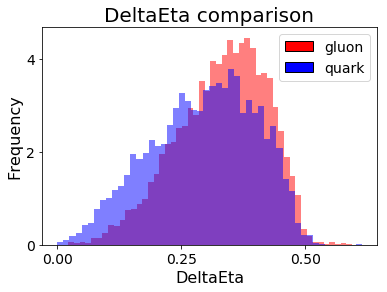

In [25]:
compare_hist('DeltaEta')

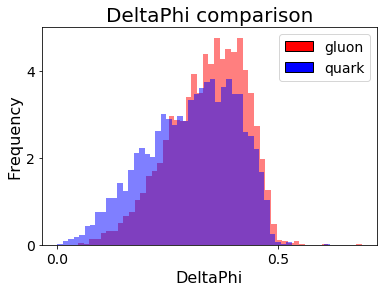

In [26]:
compare_hist('DeltaPhi')

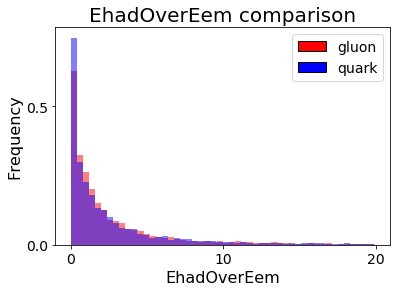

In [27]:
compare_hist('EhadOverEem')

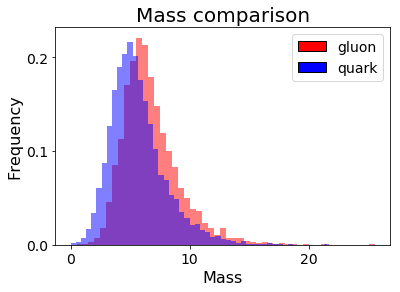

In [28]:
compare_hist('Mass')

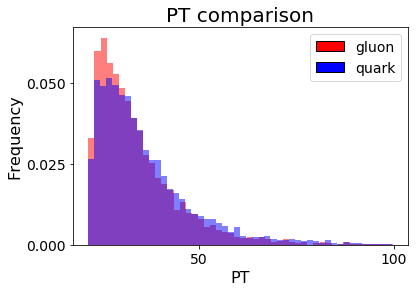

In [29]:
compare_hist('PT')

__Ratio plot for pTs__

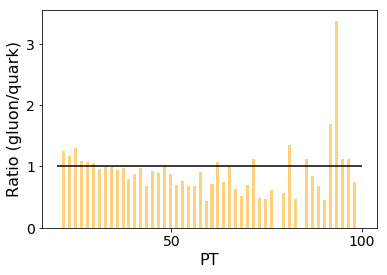

In [30]:
variable='PT'

cmd = 'y = df_train_gluon.%s' %variable
exec(cmd)
    
cmd = 'y_ = df_train_quark.%s' %variable
exec(cmd)

ns, bins, patches = plt.hist(y, 50, alpha=0, color="red", normed=1)
ns_, bins_, patches_ = plt.hist(y_, 50, alpha=0, color="blue", normed=1)

#gluon/quark ratio
ns_ratio = ns/ns_

#bar plot of ratio
ratio_plot = plt.bar(bins[:-1],ns_ratio, alpha=0.5, color="orange")

plt.ylabel("Ratio (gluon/quark)", fontsize=16)
plt.xlabel("PT", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.yticks(np.arange(0, 4, 1.0))
plt.hlines(1,20,100)

plt.show()

__Observations:__
- 
- 


## 4. Prepare the data to better expose the underlying patters to ML algorithms.

We aren't binning the jets by pT. So the only thing to do is standardize the data by removing the mean and scaling to unit variance.

__Standardizing__

In [31]:
y_train = df_train[['Label']].copy().values

X_train = df_train.drop('Label',axis=1).values

In [32]:
y_test = df_train[['Label']].copy().values

X_test = df_train.drop('Label',axis=1).values

In [33]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)

X_test = StandardScaler().fit_transform(X_test)

In [34]:
#mean is now 0.

int(X_train.mean())

0

In [35]:
#standard deviation is now 1.

int(X_train.std())

1

## 5. Explore many different models and short-list the best ones.

I'll only experiment with SVC for now.

In [36]:
from sklearn.svm import SVC

In [37]:
svm_clf = SVC()
svm_clf.fit(X_train, np.ravel(y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
from sklearn.model_selection import cross_val_score

def cv_score(classifier):
    score = cross_val_score(classifier, X_train, np.ravel(y_train), cv=5)
    print "Mean score:", score.mean()

In [39]:
#cv_score(svm_clf)

## 6. Fine-tune your models and combine them into a great solution.

Now I will fine-tune the SVC parameters: "gamma" and "C".

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [41]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

svm_search = RandomizedSearchCV(svm_clf, param_distributions, n_iter=3, verbose=2)
svm_search.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=8.210564782195133, gamma=0.009869745298305851 .................
[CV] .. C=8.210564782195133, gamma=0.009869745298305851, total=   1.7s
[CV] C=8.210564782195133, gamma=0.009869745298305851 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .. C=8.210564782195133, gamma=0.009869745298305851, total=   1.6s
[CV] C=8.210564782195133, gamma=0.009869745298305851 .................
[CV] .. C=8.210564782195133, gamma=0.009869745298305851, total=   1.5s
[CV] C=7.771481225399438, gamma=0.03811873799337567 ..................
[CV] ... C=7.771481225399438, gamma=0.03811873799337567, total=   1.9s
[CV] C=7.771481225399438, gamma=0.03811873799337567 ..................
[CV] ... C=7.771481225399438, gamma=0.03811873799337567, total=   1.9s
[CV] C=7.771481225399438, gamma=0.03811873799337567 ..................
[CV] ... C=7.771481225399438, gamma=0.03811873799337567, total=   2.0s
[CV] C=9.05702683671655, gamma=0.02616095675610388 ...................
[CV] .... C=9.05702683671655, gamma=0.02616095675610388, total=   1.9s
[CV] C=9.05702683671655, gamma=0.02616095675610388 ...................
[CV] .... C=9.05702683671655, gamma=0.02616095675610388, total=   1.9s
[CV] C=9.05702683671655, gamma=0.02616095675610388 ...................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.4s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12291e610>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x122829c10>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [42]:
svm_search.best_estimator_

SVC(C=7.771481225399438, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03811873799337567,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [43]:
svm_search.best_score_

0.662528216704289

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 801, in __bootstrap_inner
  File "<decorator-gen-24>", line 2, in run
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/history.py", line 60, in needs_sqlite
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/history.py", line 843, in run
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/iostream.py", line 376, in write
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/iostream.py", line 203, in schedule
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/iostream.py", line 101, in _event_pipe
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/zmq/sug

## 7. Present your solution.

__Accuracy__

In [44]:
y_pred = svm_search.best_estimator_.predict(X_test)

print "Accuracy: ", accuracy_score(y_test, y_pred)

Accuracy:  0.6711813393528969


__ROC Curve__

In [45]:
#fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1051, in getinnerframes
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1011, in getframeinfo
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 453, in getsourcefile
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 482, in getmodule
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 466, in get

IndexError: string index out of range

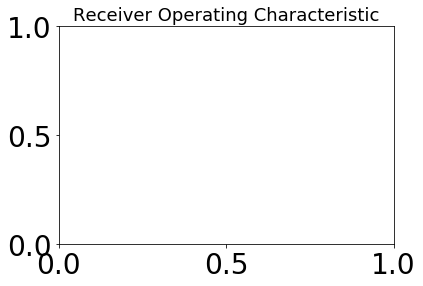

In [46]:
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(tpr,1-fpr, 'b', color='darkorange', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc='lower left', fontsize=14)
plt.plot([0,1],[1,0],'r--', color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Gluon Jet Rejection (TNR)', fontsize=16)
plt.xlabel('Quark Jet Efficiency (TPR)', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.savefig("roc_sol3.png")
plt.show()

__AUC__

In [47]:
print "AUC: ", roc_auc

AUC:  0.6716088068181819


## 8. Launch, monitor, and maintain your system.

***
## Appendix

Markdown examples: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

Latex examples:
http://data-blog.udacity.com/posts/2016/10/latex-primer/